In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

set_seed(1)

In [2]:
def prepare_data(dataset_path_train = None,dataset_path_test = None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    train = pd.read_csv(dataset_path_train)
    test = pd.read_csv(dataset_path_test)
    
    y_train = train['label']
    y_test = test['label']
    
    X_train = train[['roberta_prediction', 'text']]
    X_test = test[['roberta_prediction', 'text']]
    
    return X_train, y_train, X_test, y_test

def prepare_lex_data(dataset_path_train = None,dataset_path_test = None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    train = pd.read_csv(dataset_path_train)
    test = pd.read_csv(dataset_path_test)
    
    y_train = train['label']
    y_test = test['label']
    
    features = []
    for feat in train.columns.values:
        if 'lex' in feat:
            features.append(feat)
    features.extend(['roberta_prediction', 'syntax_ari', 'social_karma'])
    
    X_train = train[features]
    X_test = test[features]
    
    return X_train, y_train, X_test, y_test

def evaluate(test_labels, y_pred):
    acc = accuracy_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred, zero_division=1)
    prec = precision_score(test_labels, y_pred, zero_division=1)
    f1 = f1_score(test_labels, y_pred, zero_division=1)
    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("Precision: ", prec)
    print("F1: ", f1)

In [3]:
from empath import Empath
lexicon = Empath()

def empath(X):
    rows = []
    for t in X['text']:
        empath = lexicon.analyze(t, normalize=True)
        rows.append(pd.DataFrame([empath]))
    df = pd.concat(rows, ignore_index=True)
    X = pd.concat([X,df], axis=1)
    return X.drop(columns=['text'])

In [4]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')
X_train = empath(X_train)
X_test = empath(X_test)

In [5]:
import phik
def pairs(X, threshold):
    corr =  X.phik_matrix(interval_cols=X.columns)
    columns = corr.columns
    high_corr = dict()
    feature_corr_n = dict.fromkeys(X.columns, 0)
    for column1 in columns:
        for column2 in columns:
            value = corr[column1][column2]
            if value > threshold and column1 != column2 and (column2, column1) not in high_corr:
                high_corr[(column1,column2)] = value
    return high_corr

In [6]:
def cutoff_features(threshold, X):
    corr_matrix =  X.phik_matrix(interval_cols=X.columns)
    upper_tri = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > float(threshold))]
    return to_drop
to_drop = cutoff_features(0.85, X_train)

In [7]:
to_drop

['health',
 'banking',
 'night',
 'college',
 'exasperation',
 'reading',
 'worship',
 'eating',
 'water',
 'legend',
 'neglect',
 'swimming',
 'love',
 'sympathy',
 'vehicle',
 'disgust',
 'sound',
 'sailing',
 'warmth',
 'fun',
 'joy',
 'affection',
 'lust',
 'shame',
 'anger',
 'car',
 'technology',
 'power',
 'white_collar_job',
 'party',
 'cleaning',
 'competing',
 'ocean',
 'contentment',
 'musical']

In [8]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

hp = {
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'penalty': ['l2', 'elasticnet'],
        'C': [0.1, 1, 10],
}

sclr = StandardScaler()
X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.transform(X_test)
gs_model = GridSearchCV(LogisticRegression(max_iter=1000000), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train_s, y_train)

model = LogisticRegression(max_iter=1000000, **gs_model.best_params_)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\38599\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 71, in _check_solver
    raise ValueError(
Value

Accuracy:  0.8223776223776224
Recall:  0.8970189701897019
Precision:  0.7880952380952381
F1:  0.8390367553865653


In [10]:
cdf = pd.DataFrame(model.coef_.transpose(), X_train.columns, columns=['coefficient'])
print(cdf.sort_values(by='coefficient',  key=abs, ascending=False).to_string())

                       coefficient
roberta_prediction        3.788742
nervousness               0.132881
negative_emotion          0.118690
pain                      0.105791
violence                  0.090998
fear                      0.080961
suffering                 0.070243
sadness                   0.063180
body                      0.056020
communication            -0.052343
hate                      0.047315
friends                  -0.043832
children                 -0.043718
internet                 -0.042569
cold                      0.040574
meeting                  -0.040475
listen                   -0.039278
phone                    -0.035543
messaging                -0.035529
speaking                 -0.032002
help                     -0.029985
childish                 -0.029703
traveling                -0.029033
money                    -0.027654
horror                    0.026969
computer                 -0.026148
family                   -0.025500
medical_emergency   

In [11]:
from sklearn.svm import SVC

sclr = StandardScaler()
X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.transform(X_test)
hp = {
        'kernel': ['linear'],
        'gamma': [1000, 100, 10, 1, 0.1, 0.01],
        'C': [0.01, 0.1, 1, 10],
    }
gs_model = GridSearchCV(SVC(), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train_s, y_train)
    
model = SVC(**gs_model.best_params_)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy:  0.8167832167832167
Recall:  0.9105691056910569
Precision:  0.7741935483870968
F1:  0.8368617683686178


In [12]:
X_train_l, y_train, X_test_l, y_test = prepare_lex_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')

In [13]:
model_l = LogisticRegression(max_iter=1000000)
model_l.fit(X_train_l, y_train)
y_pred_l = model_l.predict(X_test_l)
evaluate(y_test, y_pred_l)

Accuracy:  0.8195804195804196
Recall:  0.907859078590786
Precision:  0.7790697674418605
F1:  0.8385481852315394


In [14]:
X_train_b, y_train, X_test_b, y_test = prepare_lex_data(dataset_path_train = 'train_pred_base_roberta.csv', dataset_path_test = 'test_pred_base_roberta.csv')

In [15]:
model_b = LogisticRegression(max_iter=1000000)
model_b.fit(X_train_b, y_train)
y_pred_b = model_b.predict(X_test_b)
evaluate(y_test, y_pred_b)

Accuracy:  0.8125874125874126
Recall:  0.8861788617886179
Precision:  0.7804295942720764
F1:  0.8299492385786803


In [16]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.plotting import checkerboard_plot

def testsig(y_test, y_model1, y_model2, alpha=0.05):
    tb = mcnemar_table(y_target=y_test, 
                   y_model1=y_pred_b, 
                   y_model2=y_pred)
    brd = checkerboard_plot(tb,
                        figsize=(4, 4),
                        fmt='%d',
                        col_labels=['model 2 correct', 'model 2 incorrect'],
                        row_labels=['model 1 correct', 'model 1 incorrect'])
    
    result = mcnemar(tb, exact=False)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

Base + LIWC vs Fine tuned + Empath
statistic=0.075, p-value=0.784
Same proportions of errors (fail to reject H0)


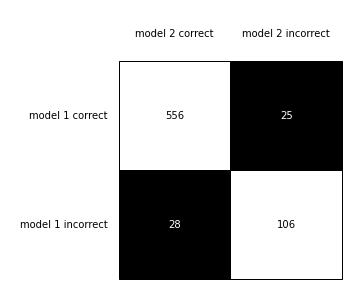

In [17]:
print('Base + LIWC vs Fine tuned + Empath')
testsig(y_test, y_pred_b, y_pred, alpha=0.05)

Our final model is not better than the one Knežević et al. used.

Fine tuned + LIWC vs Fine tuned + Empath
statistic=0.075, p-value=0.784
Same proportions of errors (fail to reject H0)


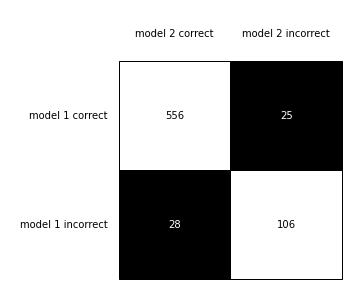

In [18]:
print('Fine tuned + LIWC vs Fine tuned + Empath')
testsig(y_test, y_pred_l, y_pred, alpha=0.05)

Empath features can replace LIWC features.

### Error analysis

In [19]:
indexes = []
predictions = []
for index, (first, second) in enumerate(zip(y_test, y_pred)):
    if first != second:
        indexes.append(index)
        predictions.append(second)
        
indexes2 = []
predictions2 = []
for index, (first, second) in enumerate(zip(y_test, y_pred_l)):
    if first != second:
        indexes2.append(index)
        predictions2.append(second)

In [20]:
sum(predictions)/len(predictions)

0.7480916030534351

In [21]:
sum(predictions2)/len(predictions2)

0.7364341085271318

In [22]:
test_ex = pd.read_csv('dreaddit-test.csv')[['text', 'label']]
for i in indexes:
    if i not in indexes2:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                  text  label
250  Asked her for help. She said "come for dinner". She's not that good of a cook. I don't talk to her anymore. I don't care anymore.      0
                                                                                                                                                                                                                                                                                                                                                                                                      text  label
616  He didn't remember, and didn't care that they weren't in the file any longer. He said he had 400 cases on his docket and couldn't remember something so trivial. He didn't care to look at my phone or email, because bond didn't matter when the case wasn't going to win. I started to feel like I was detaching an

In [23]:
test_ex = pd.read_csv('dreaddit-test.csv')[['text', 'label']]
for i in indexes2:
    if i not in indexes:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  label
435  Moving on to the following workday, I went over to the shop to collect the dishes from the stuff I brought to the party. I had a beer and chilled with the gang. Then the owner of the shop busts out with his wife's concerns that he and I were "after each other". My not-so-savvy self didn't know what he meant at first. But as the realization washed over me that I was being suspected of an affair I was mortified horrified and shamified.      1


In [24]:
inter = np.intersect1d(indexes, indexes2)
suma = 0
for i in inter:
    print(test_ex.loc[[i]].to_string())
    suma += test_ex['label'].iloc[i]

                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  label
4  I haven’t said anything to him yet because I’m not sure how someone would take hearing that their partner has such fluctuations of feelings towards them (especially since he told me he loves me and is somewhat clingy). Nonetheless, I know a conversation will need to be had but I want to get my feelings in order first. What would y’all recommend, Reddit? TL;DR I have “hot and warm” feelings towards my boyfriend. Can’t figure out why.      0
                                                                                                          

83  Please, I'm NOT looking for any handouts. That's the last thing in the world I need. I WANT to pay back every penny that's loaned to me. I just feel like this is too big of a loan to ask on /r/borrow, and I'm stuck in such a rut. I've found a few nice cars around here that I feel would fit the bill in the $2500 price range, and then tax, tag and title, and maybe a couple months of insurance payment.      0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  label
85  I just wanted to say thank you to everyone that posts on here. 

197  I’m  asking yall how can I live life properly? Immediately after I threw up  in year 2, I never feared it happening again. I admit when this happened  I was in tears, and same in year 3- I was crying next to my mum by the  toilet but it was over quick and again- I was eating chocolate again the  day after. But now, nausea? Stop eating for the day.      0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  label
199  I'm sorry if I didn't post this in the right place and such, it'd be really comforting if someone had this as well and told me about it. edit: another way 

269  He pretty much told me that he was angry and disappointed and would probably not forgive me for a while and that I owe him. I was going to go... I still want to. I just am looking at either going to this wedding and being evicted or not going and dealing with the disappointment. I don't feel like I have a choice.      0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text  label
273  He wanted me to say once again that of course I was in the wrong and I need to change my selfish ways and give him the kind of love he deserves. When I stated I need space,

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  label
320  However, his fits of anger kept going at the smallest things such as eating the rest of the corn chips or even mentioning politics that he doesn't agree with. This went on at the same rate of once a month or so until I turned 16, which is when I noticed that it probably wasn't normal. One occurrence of this was when I was trying to buy a pair of sunglasses, but needed to use hi

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  label
487  SIL and BIL are seeing s couples therapist as well as individual therapists. SIL is adamant that she wants my wife and I to participate in group therapy with both of them and that my BIL wants to set the record straight and feels awkward around our family. He hasn't personally apologized for his actions and states that my SIL fell and hit her head on dumbbells in their apt. I do not believe him. He has only apologized that we had to deal with the entire mess.      0
                                                

542  The curfew at the shelter keeps me grounded and safe from myself. The rules and the structure with morning routine even though I've just felt it for one day, has already boosted me. I used to stay up until 2-3am, blowing all my money just binging and purging. Now I have to pause and ride out my emotions. I have to be in bed at 10pm.      0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          text  label
543  Well, 18 years of being in and out of hospitals, treatment and addiction finally caught up to me. This is my first time homeless and it's scary bu

                                                                                                                                                                                                                                                                                                                                                       text  label
620  My best friend died last year, of a rare type of bacteria that killed him very quickly, a contagious disease. He was a year younger than me. I am still relatively young but also starting to get old, my age is in between somewhere. I can feel the medicine starting to work and I am not as anxious now. I have been typing for over half an hour.      1
                                                                                                                                                                                                                                                                      text  label
622  I need to b